# Compute stats about PoS tags

**Goal**: sample of Lux data to test `spellux` lemmatization

**Logic**:
- ...

## imports

In [2]:
from impresso_commons.utils.s3 import get_s3_client, alternative_read_text, IMPRESSO_STORAGEOPT
from impresso_commons.utils.s3 import fixed_s3fs_glob
from impresso_commons.utils.kube import (
    make_scheduler_configuration,
    make_worker_configuration,
)
from dask_k8 import DaskCluster
from dask import bag as db
from dask.distributed import Client
import json
import os
import codecs
import pandas as pd
import matplotlib

## local dask cluster

In [2]:
dask_client = Client()
dask_client.scheduler_info()['services']['dashboard']

/home/romanell/.pyenv/versions/3.6.7/envs/impresso-sanity-check/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


41353

## setup dask k8 cluster

In [ ]:
dask_client = Client()
dask_client.scheduler_info()['services']['dashboard']

In [35]:
image_uri = "ic-registry.epfl.ch/dhlab/impresso_pycommons:v1"
memory = "20G"
# memory = "1G"
n_workers = 100

In [36]:
print(make_worker_configuration(
        docker_image=image_uri,
        memory=memory
    ))


      containers:
        - image: ic-registry.epfl.ch/dhlab/impresso_pycommons:v1
          args: [dask-worker, $(DASK_SCHEDULER_ADDRESS), --nthreads, '1', --no-bokeh, --memory-limit, 20G, --death-timeout, '120']
          imagePullPolicy: Always
          name: dask-worker
          env:
            - name: POD_IP
              valueFrom:
                fieldRef:
                  fieldPath: status.podIP
            - name: POD_NAME
              valueFrom:
                fieldRef:
                  fieldPath: metadata.name
            - name: EXTRA_PIP_PACKAGES
              value: 
            - name: EXTRA_CONDA_PACKAGES
              value:
            - name: SE_ACCESS_KEY
              value: 18c8f162ee474359ba3a6dbf08edca0f
            - name: SE_SECRET_KEY
              value: 733f24dbbef045b480da0fdd088a92b6
          resources:
            requests:
              cpu: 1
              memory: 20G
            limits:
              cpu: 1
              memory: 20G
         

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
_GatheringFuture exception was never retrieved
future: <_Gathering

In [37]:
worker_config = """
      containers:
        - image: ic-registry.epfl.ch/dhlab/impresso_pycommons:v1
          args: [dask-worker, $(DASK_SCHEDULER_ADDRESS), --nthreads, '1', --no-bokeh, --memory-limit, 20G, --death-timeout, '120']
          imagePullPolicy: Always
          name: dask-worker
          env:
            - name: POD_IP
              valueFrom:
                fieldRef:
                  fieldPath: status.podIP
            - name: POD_NAME
              valueFrom:
                fieldRef:
                  fieldPath: metadata.name
            - name: EXTRA_PIP_PACKAGES
              value: 
            - name: EXTRA_CONDA_PACKAGES
              value:
            - name: SE_ACCESS_KEY
              value: 18c8f162ee474359ba3a6dbf08edca0f
            - name: SE_SECRET_KEY
              value: 733f24dbbef045b480da0fdd088a92b6
          resources:
            requests:
              cpu: 1
              memory: 20G
            limits:
              cpu: 1
              memory: 20G
          volumeMounts:
            - mountPath: /shared_volume
              name: site-data
      volumes:
        - name: site-data
          persistentVolumeClaim:
            claimName: dhlab-scratch
"""

In [38]:
cluster = DaskCluster(
    namespace="dhlab",
    cluster_id="impresso-load",
    scheduler_pod_spec=make_scheduler_configuration(),
    worker_pod_spec=worker_config
)
cluster.create()
cluster.scale(n_workers, blocking=False)
dask_client = cluster.make_dask_client()

Scheduler: tcp://10.90.49.5:10806
Dashboard: http://10.90.49.5:11595


In [34]:
cluster.close()

In [44]:
dask_client

Client Scheduler: tcp://10.90.49.5:10806 Dashboard: http://10.90.49.5:8787/status,Cluster Workers: 59 Cores: 59 Memory: 1.18 TB


## configuration

In [45]:
S3_LANGID_BUCKET = "s3://processed-canonical-data/langident/v01"
S3_OCRQA_BUCKET = "s3://processed-canonical-data/ocrqa/ocrqa004/"
S3_CANONICAL_DATA_BUCKET = "s3://original-canonical-fixed"
S3_REBUILT_DATA_BUCKET = "s3://canonical-rebuilt-release"
S3_STATS_BUCKET = "s3://impresso-stats/content-item-stats/"
S3_LINGPROCESSED_BUCKET = "s3://processed-canonical-data/linguistic-processing/2020-03-11/"

## read linguistically processed data

In [46]:
input_files = fixed_s3fs_glob(
    os.path.join(S3_LINGPROCESSED_BUCKET, '*.bz2')
)

In [47]:
len(input_files)

3040

In [48]:
test = db.read_text(
    input_files,
    storage_options=IMPRESSO_STORAGEOPT
).map(json.loads)

In [49]:
def docs2postags(documents):
    return [
        {
            "ci_id": document['id'],
            "lang": sentence['lg'],
            "pos": token['p']
        }
        for document in documents
        for sentence in document['sents']
        for token in sentence['tok']
    ]

In [50]:
df = test.map_partitions(docs2postags).to_dataframe()

In [51]:
pos_counts_df = pd.DataFrame(df.groupby(['lang', 'pos']).size().compute()).rename(columns={0: 'count'})

In [52]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client -

In [61]:
pos_counts_df

count
lang pos              
fr             1635211
     ADJ     552447071
     ADP    1030500176
     ADV     309902383
     AUX     260788440
...                ...
lb   VERB      1097844
     AUX        387595
     X            1711
     SPACE         499
en   SPACE           5

[66 rows x 1 columns]

In [54]:
pos_counts_df['count'].sum()

14604674510

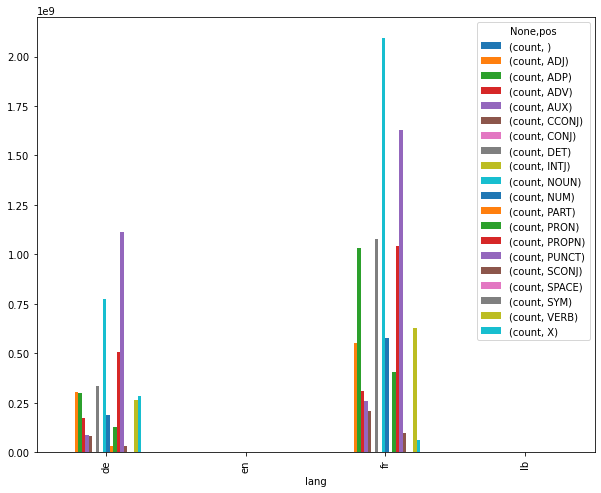

In [63]:
pos_counts_df.unstack().plot(kind='bar', figsize=(10, 8))

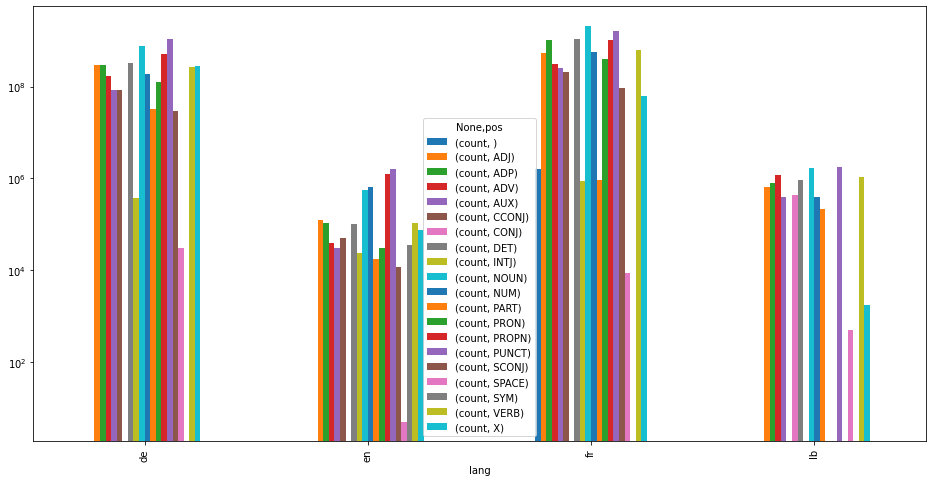

In [66]:
pos_counts_df.unstack().plot(
    kind='bar',
    figsize=(16, 8),
    logy=True,
    
)

The PoS tagset used by spacy can be found [here](https://spacy.io/api/annotation)

- `ADJ`	*adjective*	big, old, green, incomprehensible, first
- `ADP`	*adposition*	in, to, during
- `ADV`	*adverb*	very, tomorrow, down, where, there
- `AUX`	*auxiliary*	is, has (done), will (do), should (do)
- `CONJ`	*conjunction*	and, or, but
- `CCONJ`	*coordinating conjunction*	and, or, but
- `DET`	*determiner*	a, an, the
- `INTJ`	*interjection*	psst, ouch, bravo, hello
- `NOUN`	*noun*	girl, cat, tree, air, beauty
- `NUM`	*numeral*	1, 2017, one, seventy-seven, IV, MMXIV
- `PART`	*particle*	’s, not,
- `PRON`	*pronoun*	I, you, he, she, myself, themselves, somebody
- `PROPN`	*proper noun*	Mary, John, London, NATO, HBO
- `PUNCT`	*punctuation*	., (, ), ?
- `SCONJ`	*subordinating conjunction*	if, while, that
- `SYM`	*symbol*	$, %, §, ©, +, −, ×, ÷, =, :), 😝
- `VERB`	*verb*	run, runs, running, eat, ate, eating
- `X`	*other*	sfpksdpsxmsa
- `SPACE`	*space*

In [172]:
postag_whitelist = [
    'NOUN', 'NUM', 'PROPN', 'VERB', 'ADJ'
]

In [169]:
total_tokens_n = 0
kept_tokens_n = 0

for lang in list(pos_counts_df.unstack().index):
    for column, pos_tag in pos_counts_df.unstack().loc[lang].index:
        idx = (column, pos_tag)
        
        if pos_tag in postag_whitelist:
            n_tokens = pos_counts_df.unstack().loc[lang].loc[idx]
            if not pd.isnull(n_tokens):
                kept_tokens_n += int(n_tokens)
                print(lang, pos_tag, int(n_tokens))
        else:
            n_tokens = pos_counts_df.unstack().loc[lang].loc[idx]
            if not pd.isnull(n_tokens):
                total_tokens_n += int(n_tokens)
                print(lang, pos_tag, int(n_tokens))

de ADJ 302598008
de ADP 300593197
de ADV 173025728
de AUX 86019268
de CCONJ 83644396
de DET 335061025
de INTJ 380468
de NOUN 776736218
de NUM 190571510
de PART 32634508
de PRON 129238012
de PROPN 508591936
de PUNCT 1112841276
de SCONJ 29415104
de SPACE 30023
de VERB 265143104
de X 284525503
en ADJ 124415
en ADP 109382
en ADV 38654
en AUX 30185
en CCONJ 50437
en DET 99755
en INTJ 23776
en NOUN 561926
en NUM 639248
en PART 17575
en PRON 30300
en PROPN 1277407
en PUNCT 1589996
en SCONJ 11563
en SPACE 5
en SYM 35047
en VERB 108977
en X 76802
fr  1635211
fr ADJ 552447071
fr ADP 1030500176
fr ADV 309902383
fr AUX 260788440
fr CCONJ 207330699
fr DET 1075882026
fr INTJ 858671
fr NOUN 2092955413
fr NUM 578054716
fr PART 919177
fr PRON 407388010
fr PROPN 1042696683
fr PUNCT 1631150626
fr SCONJ 96099101
fr SPACE 8816
fr VERB 628529309
fr X 61943995
lb ADJ 646058
lb ADP 813268
lb ADV 1218322
lb AUX 387595
lb CONJ 446204
lb DET 930131
lb NOUN 1730308
lb NUM 401757
lb PART 219439
lb PUNCT 1816117
lb

In [170]:
total_tokens_n

8515578154

In [171]:
kept_tokens_n

6089096356

\# 1 billion adjectives